In [5]:
%matplotlib inline

import numpy as np
import pylab as plt
import ngene as ng
from ngene.architectures.simple import architecture
import ccgpack as ccg
import tensorflow as tf
from tqdm import tqdm, trange
from scipy.stats import ttest_ind

cl = np.load('../data/cl_planck_lensed.npy')
sfs = ccg.StochasticFieldSimulator(cl)
size = 7.2

class DataProvider(object):
    
    def __init__(self,nside,size,alpha,num,n_buffer=200,reinit=1000):
        
        self.nside = nside
        self.alpha = alpha
        self.num = num
        self.size = size
        self.n_buffer = n_buffer
        self.reinit = reinit
        self.couter = 0
        
    def simulate(self):
        
        s = np.zeros((self.nside, self.nside), dtype=np.double)
        begins = ccg.random_inside(s,num=self.num)
        ends = ccg.random_inside(s,num=self.num)

        g = sfs.simulate(self.nside,self.size)
        g -= g.min()
        g /= g.max()    
        s = ccg.draw_line(s,begins=begins,ends=ends,value=1)

        return g,s
    
    def simulation_initiation(self):
        gs = []
        ss = []    
#         for i in tqdm(range(self.n_buffer), total=self.n_buffer, unit=" map", desc='Initiation', ncols=70):
        for i in range(self.n_buffer):
            g,s = self.simulate()
            gs.append(g)
            ss.append(s)
        return np.array(gs),np.array(ss)
        
    def __call__(self,n,alpha=None):
        
        if self.couter%self.reinit==0:
            self.gs, self.ss = self.simulation_initiation()
        if alpha is None:
            alpha = self.alpha
        self.couter += 1
        x_out = []
        y_out = []
        for i in range(n):
            i_g,i_s = np.random.randint(0,self.n_buffer,2)
            x_out.append(self.gs[i_g]+alpha*self.ss[i_s])
            y_out.append(self.ss[i_s])
            
        x_out = np.array(x_out)
        y_out = np.array(y_out)
        return np.expand_dims(x_out,-1),np.expand_dims(y_out,-1)
        

(-0.5, 199.5, 199.5, -0.5)

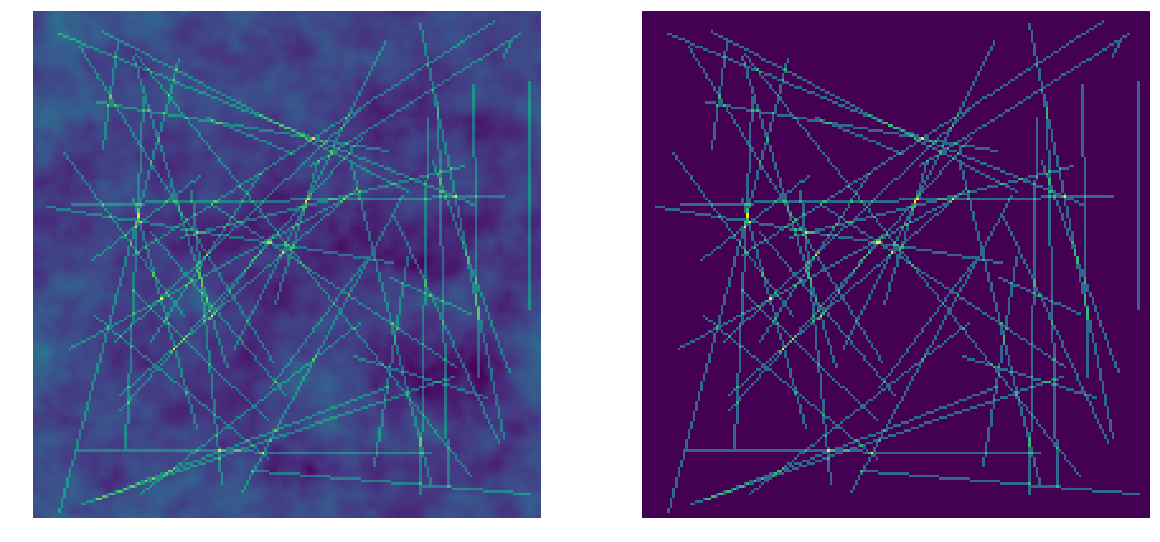

In [2]:
nside=200
dp = DataProvider(nside=nside,size=7,alpha=0.7,num=50)
dp0 = DataProvider(nside=nside,size=7,alpha=0,num=50,n_buffer=100)
x,y = dp0(1)
x,y = dp(1)

fig, (ax1,ax2)= plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
ax1.imshow(x[0,:,:,0])
ax1.axis('off')
ax2.imshow(y[0,:,:,0])
ax2.axis('off')

In [3]:
def arch(x_in):
    x_out = architecture(x_in=x_in,n_layers=5,res=2)
    return x_out

def check(model,dp,dp0):
    l0 = []
    l1 = []
    for i in range(100):
        x,y = dp(1)
        x0,y = dp0(1)
        l0.append(model.conv(x0).std())
        l1.append(model.conv(x).std())
    b0,h0 = ccg.pdf(l0,20)
    b1,h1 = ccg.pdf(l1,20)
    plt.plot(b0,h0)
    plt.plot(b1,h1)
    print('p-value:',ttest_ind(l0,l1)[1])
    return ttest_ind(l0,l1)[1]

In [4]:
model = ng.Model(nx=nside,ny=nside,n_channel=1,n_class=1,
         restore=0,model_add='./model/'+str(0),arch=arch)

print('# of variables:',model.n_variables)

Tensor("layer_1_act:0", shape=(?, 200, 200, 12), dtype=float32)
Tensor("layer_2_act:0", shape=(?, 200, 200, 12), dtype=float32)
Tensor("layer_3_act:0", shape=(?, 200, 200, 12), dtype=float32)
Tensor("layer_4_act:0", shape=(?, 200, 200, 12), dtype=float32)
Res layer 4 + 2 :
Tensor("add:0", shape=(?, 200, 200, 12), dtype=float32)
Tensor("layer_5_norm/FusedBatchNorm:0", shape=(?, 200, 200, 1), dtype=float32)
# of variables: 11547


In [5]:
# model.train(data_provider=dp,training_epochs = 10,iterations=20 ,n_s = 10,
#                     learning_rate = 0.01, time_limit=None,
#                     metric=None, verbose=1,death_preliminary_check = 30,
#                     death_frequency_check = 1000)
# pv = check()

Training model ./model/0 alpha:0.7
Epoch:0, cost= 652133832.337109
p-value: 1.6007531880523406e-166
Training model ./model/1 alpha:0.6499999999999999
Epoch:0, cost= 41960.107812
p-value: 2.0124099595179008e-169
Training model ./model/2 alpha:0.5999999999999999
Epoch:0, cost= 40423.691406
p-value: 1.7195708748450708e-176
Training model ./model/3 alpha:0.5499999999999998
Epoch:0, cost= 43100.087891
p-value: 5.6021886674304905e-106
Training model ./model/4 alpha:0.49999999999999983
Epoch:0, cost= 39595.119922
p-value: 1.3491622873640617e-170
Training model ./model/5 alpha:0.44999999999999984
Epoch:0, cost= 37490.789844
p-value: 3.8265806857104356e-169
Training model ./model/6 alpha:0.39999999999999986
Epoch:0, cost= 32913.255469
p-value: 2.150585603226361e-177
Training model ./model/7 alpha:0.34999999999999987
Epoch:0, cost= 31427.015039
p-value: 1.6966838203359996e-161
Training model ./model/8 alpha:0.2999999999999999
Epoch:0, cost= 33228.390234
p-value: 4.711282775475204e-178
Training m

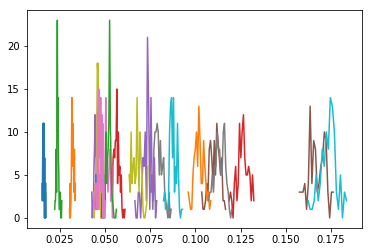

In [7]:
alphas = []
success = []
dalpha = 0.05
pv_lim = 1e-7
training_epochs = 5
iterations=10
n_s = 10
i = 0

for _ in range(50):
    
    alphas.append(dp.alpha)
    model.model_add='./model/'+str(i)
    print('Training model:{}, alpha:{}'.format(model.model_add,dp.alpha))
    model.train(data_provider=dp,training_epochs=training_epochs,
                        iterations=iterations,n_s=n_s,
                        learning_rate=0.01, time_limit=None,
                        metric=None, verbose=1,death_preliminary_check=30,
                        death_frequency_check=1000)
    
    pv = check(model,dp,dp0)
    if pv>pv_lim and i!=0:
        dp.alpha = dp.alpha+dalpha
        if np.random.uniform()>0.5:
            dalpha = dalpha/2  
        model.model_add='./model/'+str(i-1)
        model.restore()
    else:
        dp.alpha = dp.alpha-dalpha
        i += 1  
        
    success.append(pv<pv_lim)
        
    

Epoch:0, cost= 47850.981250
Epoch:1, cost= 47451.963672
Epoch:2, cost= 48573.077734
Epoch:3, cost= 48236.819531
Epoch:4, cost= 47112.295312
p-value: 0.5978785270171152
0.5978785270171152
0.0468749999999999
Epoch:0, cost= 47535.765625
Epoch:1, cost= 361749.996484
Epoch:2, cost= 49105.009766
Epoch:3, cost= 48126.283594
Epoch:4, cost= 48032.672266
p-value: 0.9472421486399416
0.9472421486399416
0.0518749999999999
Epoch:0, cost= 47530.024609
Epoch:1, cost= 48471.473828
Epoch:2, cost= 47126.287109
Epoch:3, cost= 47225.397266
Epoch:4, cost= 46167.572266
p-value: 1.5545982350252792e-55
1.5545982350252792e-55
0.0493749999999999
Epoch:0, cost= 47585.596484
Epoch:1, cost= 46939.008203
Epoch:2, cost= 49219.617188
Epoch:3, cost= 47553.648828
Epoch:4, cost= 47157.132812
p-value: 0.6629048707506324
0.6629048707506324
0.0506249999999999
Epoch:0, cost= 48555.291016
Epoch:1, cost= 48914.818359
Epoch:2, cost= 48738.206641
Epoch:3, cost= 48736.185156
Epoch:4, cost= 48982.704297
p-value: 0.2199898018571687

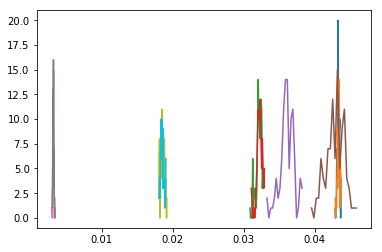

In [43]:
alphas = []
success = []

dalpha = 0.005
p_move = 0

for i in range(5):

    model.train(data_provider=dp,training_epochs = 5,iterations=10 ,n_s = 10,
                        learning_rate = 0.01, time_limit=None,
                        metric=None, verbose=1,death_preliminary_check = 30,
                        death_frequency_check = 1000)
    pv = check()
    print(pv)
    if pv<1e-7:
        if p_move == 1:
            dalpha = dalpha/2
            while dalpha>dp.alpha:
                dalpha = dalpha/2
        dp.alpha = dp.alpha-dalpha
        p_move = -1
    else:
        if p_move == -1:
            dalpha = dalpha/2
            while dalpha>dp.alpha:
                dalpha = dalpha/2
        dp.alpha = dp.alpha+dalpha
        p_move = 1
        
    success.append(p_move)    
    
    alphas.append(dp.alpha)
    print(dp.alpha)
        
    model.model_add='./model/'+str(i+1)+'_'+str(dp.alpha)

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,nrows=1,figsize=(15,7))

x,y = dp(1)
x_pred = model.conv(x)

ax1.imshow(x[0,:,:,0])
ax1.set_title('Input')
ax2.imshow(y[0,:,:,0])
ax2.set_title('Output')
ax3.imshow(x_pred[:,:,0])
ax3.set_title('Prediction')